In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import *
from scipy import stats

#Test-Train Split

In [2]:
smalldf = pd.read_csv("small.csv")

In [3]:
smalldf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_FACED,ov_AVG,ov_OBP,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT,ovp_AVG,ovp_OBP
0,tejar001,alvah001,10,2,13,R,0,1,2,3,tejar001_alvah001,652,176,720,11,90,275,68,55,0.269939,0.338889,0.125,0.094444,0.244444,1055,283,1139,8,142,553,84,86,0.124671,0.073749,0.248464,0.268246,0.322212
1,tejar001,bumgm001,10,1,10,L,0,3,1,0,tejar001_bumgm001,652,176,720,11,90,275,68,55,0.269939,0.338889,0.125,0.094444,0.244444,1993,504,2150,21,450,943,157,133,0.209302,0.073023,0.234419,0.252885,0.307442
2,tejar001,burna001,9,1,9,R,0,3,1,0,tejar001_burna001,652,176,720,11,90,275,68,55,0.269939,0.338889,0.125,0.094444,0.244444,7071,1796,7960,89,1630,3477,889,404,0.204774,0.111683,0.225628,0.253995,0.337312
3,tejar001,cainm001,13,5,14,R,0,4,9,1,tejar001_cainm001,652,176,720,11,90,275,68,55,0.269939,0.338889,0.125,0.094444,0.244444,4691,1161,5230,61,954,2350,539,257,0.182409,0.103059,0.221989,0.247495,0.325048
4,tejar001,corrk001,10,3,10,R,0,0,7,0,tejar001_corrk001,652,176,720,11,90,275,68,55,0.269939,0.338889,0.125,0.094444,0.244444,3502,1015,3853,37,512,1969,351,242,0.132883,0.091098,0.263431,0.289834,0.354529


In [4]:
smalldf.dtypes

bID            object
pID            object
AB              int64
H               int64
PA              int64
RL             object
SAC             int64
SO              int64
TB              int64
W               int64
matchID        object
ov_AB           int64
ov_H            int64
ov_PA           int64
ov_SAC          int64
ov_SO           int64
ov_TB           int64
ov_W            int64
ov_FACED        int64
ov_AVG        float64
ov_OBP        float64
ov_SO_PCT     float64
ov_W_PCT      float64
ov_H_PCT      float64
ovp_AB          int64
ovp_H           int64
ovp_PA          int64
ovp_SAC         int64
ovp_SO          int64
ovp_TB          int64
ovp_W           int64
ovp_FACED       int64
ovp_SO_PCT    float64
ovp_W_PCT     float64
ovp_H_PCT     float64
ovp_AVG       float64
ovp_OBP       float64
dtype: object

In [5]:
smalldf['AVG'] = smalldf['H']/smalldf['AB']
smalldf['OBP'] = (smalldf['H'] + smalldf['W'])/smalldf['PA']

In [6]:
#Copied and pasted over from Baseline model

trainlist=[]
testlist=[]
validatelist=[]
take=21 #11 matchups between validation and test set
for k, v in smalldf.groupby('bID'):
    if len(v) > 100: #batter has faced at least 150 pitchers
        train_rows, test_valid_rows = train_test_split(v, test_size=take)
        trainlist.append(train_rows)
        valid_rows, test_rows = train_test_split(test_valid_rows, test_size=0.4)
        validatelist.append(valid_rows) 
        testlist.append(test_rows) 
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(87729, 39) (4716, 39) (3537, 39)


#Make the uuids and uiids from the traindf for each batter and pitcher

In [7]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids

In [8]:
from sklearn.linear_model import Ridge
features=np.concatenate([ubids,upids])
features.shape

(1503L,)

In [9]:
traindf.head(10)

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_FACED,ov_AVG,ov_OBP,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT,ovp_AVG,ovp_OBP,AVG,OBP
6387,abreb001,david002,16,5,19,L,0,4,17,3,abreb001_david002,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,4719,1338,5376,67,825,2557,657,282,0.153460,0.122210,0.248884,0.283535,0.371094,0.312500,0.421053
6319,abreb001,alfoa001,12,5,15,R,0,2,8,3,abreb001_alfoa001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,898,269,1038,17,153,447,140,92,0.147399,0.134875,0.259152,0.299555,0.394027,0.416667,0.533333
6329,abreb001,aybam001,10,5,10,R,0,2,11,0,abreb001_aybam001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,405,106,449,7,59,234,44,41,0.131403,0.097996,0.236080,0.261728,0.334076,0.500000,0.500000
6624,abreb001,tejer001,9,2,10,R,0,1,4,1,abreb001_tejer001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,743,193,855,4,140,361,112,79,0.163743,0.130994,0.225731,0.259758,0.356725,0.222222,0.300000
6447,abreb001,hellr001,14,5,14,R,0,2,11,0,abreb001_hellr001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,3247,902,3614,44,562,2064,367,192,0.155506,0.101550,0.249585,0.277795,0.351134,0.357143,0.357143
6343,abreb001,billc001,12,3,12,R,0,1,5,0,abreb001_billc001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,2937,780,3332,42,632,1420,395,183,0.189676,0.118547,0.234094,0.265577,0.352641,0.250000,0.250000
6327,abreb001,astap001,31,10,41,R,0,6,23,10,abreb001_astap001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,3921,1174,4392,45,714,2426,471,183,0.162568,0.107240,0.267304,0.299413,0.374545,0.322581,0.487805
6631,abreb001,tomlj001,9,3,9,R,0,0,7,0,abreb001_tomlj001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,967,290,1038,5,126,636,71,89,0.121387,0.068401,0.279383,0.299897,0.347784,0.333333,0.333333
6487,abreb001,kuroh001,12,2,12,R,0,1,2,0,abreb001_kuroh001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,3343,865,3603,34,600,1668,260,219,0.166528,0.072162,0.240078,0.258750,0.312240,0.166667,0.166667
6425,abreb001,glovg001,7,2,9,R,0,2,8,2,abreb001_glovg001,5951,1720,6993,57,1264,3467,1042,358,0.289027,0.394966,0.180752,0.149006,0.24596,829,240,940,12,124,522,111,81,0.131915,0.118085,0.255319,0.289505,0.373404,0.285714,0.444444


In [10]:
#function to produce the design matrix
def getmats(indf):
    
    results_avg = indf['AVG']
    results_obp = indf['OBP']
    
    n_cols = len(features)
    n_rows = len(indf)
    
    #fill matrix with zeros
    mats = np.zeros((n_rows, n_cols))

    #for each element in features, check for match in every row, whether business or user, and switch to one
    for i in range(0, len(ubids)):
        for j in range(0, n_rows):
            if features[i] == indf['bID'].values[j]:
                mats[j, i] = 1
    for i in range(len(ubids), n_cols):
        for j in range(0, n_rows):
            if features[i] == indf['pID'].values[j]:
                mats[j, i] = 1
    return mats, results_avg, results_obp

In [12]:
%%time
designm, avg, obp = getmats(traindf)
validatedm, validate_avg, validate_obp = getmats(validatedf)

Wall time: 16min 34s


In [13]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [14]:
%%time

#regressing averages
from sklearn.linear_model import Ridge
alphas = [0.01, 0.1, 10, 100, 1000]
vdict={}
rdict={}
for a in alphas:
    #perform regression for each alpha and store in rdict, keyed by the alpha
    ridge_reg = Ridge(alpha=a)
    
    #we'll do the average for now
    ridge_reg = ridge_reg.fit(designm, avg)
    rdict[a]=ridge_reg
    
    #calculate the RMSE for each alpha, store in vdict
    pred = ridge_reg.predict(validatedm)
    rmse = get_rmse(pred, validate_avg)
    vdict[a]=rmse

Wall time: 1min 35s


In [15]:
vdict

{0.01: 0.1317353740902702,
 0.1: 0.13173272504499411,
 10: 0.13152397421563597,
 100: 0.1313004536373131,
 1000: 0.13217224702478186}

In [16]:
minerroralpha=min(vdict, key=vdict.get)
print minerroralpha
regr=rdict[minerroralpha] 

100


In [17]:
regr.intercept_

0.2703204294037968

In [18]:
meancept=regr.intercept_
fitratmap_b={k:regr.coef_[i] for i,k in enumerate(ubids)}
fitratmap_p={k:regr.coef_[i+len(ubids)] for i,k in enumerate(upids)}

In [19]:
train_fits={'mean':meancept, 'users':fitratmap_b, 'items':fitratmap_p}

#Prediction

In [21]:
testdm, test_avg, test_obp = getmats(testdf)

In [24]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for baseline_r 0.132278402193


C:\Users\BUCKBEAK\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


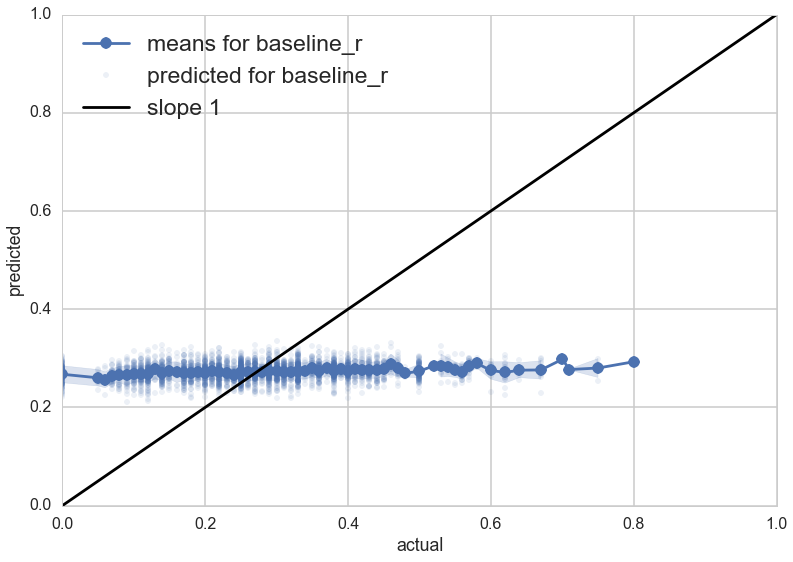

In [25]:
#Comment these out obviously
predictions={}
predictions_valid={}

from sklearn.linear_model import Ridge

pred_test = regr.predict(testdm)
predictions['baseline_r'] = pred_test

pred_valid = regr.predict(validatedm)
predictions_valid['baseline_r'] = pred_valid

compare_results(test_avg,predictions['baseline_r'], model="baseline_r", predicteds=True);

In [ ]:
#ax=plt.gca()
#compare_results(test_avg,predictions['baseline_r'], model="baseline_r", predicteds=True, axis=ax);
#compare_results(testdf.AVG,predictions['baseline'], model="baseline", predicteds=True, onsame=ax);